# Theory
Q1: Why is the KL Divergence term important in the VAE loss function?

KL divergence allows for meaningful generations of data. It is the parameter which is a measure of how far off the prediction is from reality

Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

Without parameterization, the machines cannot backpropagate through the random sampling. With the reparameterization, it is able to add noise in a controlled way by separating the noise and a differentiable function.

Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

Probabilistic latent space allows for variety in outcomes given one input, hence the 'variational'. The parameters keep the variety in check

Q4: What role does KL Divergence play in ensuring a smooth latent space?

KL Divergence is the term which adds constraints to the distributions. Encoded distributions should be close to its prior distribution. This encourages nearby inputs to be mapped to nearby points in latent space. KL divergence determines the spread of the latent distribution.

In [63]:
 !pip install torch
 !pip install torchvision

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [65]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)


        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(x.size(0), -1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [66]:
# VAE Architecture
import math

class ConvVAE(nn.Module):
    def __init__(self, size, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        numLayers = int(math.log2(size)) - 2
        self.channels = [3, 64, 128, 256, 512][:numLayers + 1]

        self.encoderLayers = []
        for i in range(len(self.channels) - 1):
            self.encoderLayers += [
                nn.Conv2d(self.channels[i], self.channels[i+1], 4, 2, 1),
                nn.BatchNorm2d(self.channels[i+1]),
                nn.ReLU()
            ]

        self.hidden_dim = self.channels[-1] * 4 * 4
        self.fc_mu = nn.Linear(self.hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim, latent_dim)
        self.conv = nn.Sequential(*self.encoderLayers)

        # Decoder

        self.fc_decode = nn.Linear(latent_dim, self.hidden_dim)

        decoderChannels = list(reversed(self.channels))
        self.decoderLayers = []

        for i in range(len(decoderChannels) - 1):
            self.decoderLayers += [
                nn.ConvTranspose2d(
                    decoderChannels[i],
                    decoderChannels[i+1],4, 2, 1
                ),
                nn.ReLU()
            ]

        self.decoderLayers[-1] = nn.Sigmoid()
        self.convTrans = nn.Sequential(*self.decoderLayers)

        self.fc2 = nn.Linear(latent_dim, self.hidden_dim)

    def encode(self, x):
        h1 = self.conv(x)
        h1=h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = self.fc2(z)
        h2 = h2.view(z.size(0), self.channels[-1], 4, 4)
        return self.convTrans(h2)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [67]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [68]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        if recon_batch.dim() == 2:
          data = data.view(data.size(0), -1)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [69]:
transform = transforms.ToTensor()
# Load MNIST dataset and run the training
#train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
#load CIFAR-10
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=3072, hidden_dim=1024, latent_dim=128)
convVae = ConvVAE(size=32, latent_dim=128)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
convOptimizer = optim.Adam(convVae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)
    train(convVae, train_loader, convOptimizer, epoch)



Epoch 1, Loss: 1955.4415940625
Epoch 1, Loss: 1908.443335625
Epoch 2, Loss: 1896.1395684375
Epoch 2, Loss: 1845.5616340625
Epoch 3, Loss: 1875.9978246875
Epoch 3, Loss: 1835.9877071875
Epoch 4, Loss: 1863.7819884375
Epoch 4, Loss: 1832.3697584375
Epoch 5, Loss: 1857.3840253125
Epoch 5, Loss: 1829.12164125
Epoch 6, Loss: 1852.744505625
Epoch 6, Loss: 1826.9347878125
Epoch 7, Loss: 1850.0049459375
Epoch 7, Loss: 1826.284098125
Epoch 8, Loss: 1847.052325625
Epoch 8, Loss: 1824.641805625
Epoch 9, Loss: 1844.15455
Epoch 9, Loss: 1823.8522890625
Epoch 10, Loss: 1842.7345740625
Epoch 10, Loss: 1823.1891625


In [70]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()
        if generated_images.dim() == 2:
            generated_images = generated_images.view(num_images, 3, 32, 32)
    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].permute(1,2,0).clamp(0,1))
        axs[i].axis('off')
    plt.show()




fully connected vae:


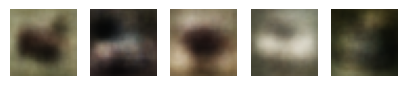

convolutional vae:


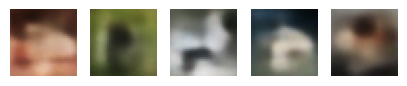

In [71]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
print('fully connected vae:')
generate_images(vae, num_images=5, latent_dim=128)

print('convolutional vae:')
generate_images(convVae, num_images=5, latent_dim=128)

While both are blurry, we can see that the convolutional vae has slightly more defined figures.

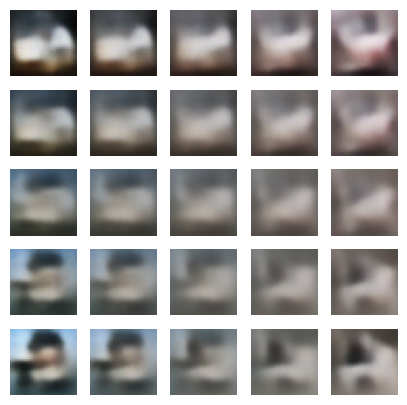

In [72]:
def interpolate_images(model, latent_dim=20):
    grid_size =5
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        zTL = torch.randn(1, latent_dim).to(next(model.parameters()).device)
        zTR = torch.randn(1, latent_dim).to(next(model.parameters()).device)
        zBL = torch.randn(1, latent_dim).to(next(model.parameters()).device)
        zBr = torch.randn(1, latent_dim).to(next(model.parameters()).device)

        z_grid = []
        for i, alpha in enumerate(torch.linspace(0, 1, grid_size)):  # vertical interpolation
            row = []
            for j, beta in enumerate(torch.linspace(0, 1, grid_size)):  # horizontal interpolation
                # Bilinear interpolation formula
                z = (1 - alpha) * ((1 - beta) * zTL + beta * zBL) + alpha * ((1 - beta) * zTR + beta * zBr)
                row.append(z)
            z_grid.append(torch.cat(row, dim=0))
        z_grid = torch.cat(z_grid, dim=0)
        generated_images = model.decode(z_grid).cpu()
        if generated_images.dim() == 2:
            generated_images = generated_images.view(grid_size, 3, 32, 32)
    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            axs[i, j].imshow(generated_images[i*grid_size + j].permute(1,2,0).clamp(0,1))
            axs[i, j].axis('off')

interpolate_images(convVae, 128)

Four points were choses as corners, and the images in between represent the values in between. From this we can see there is a smooth transition from one to another.

Epoch 1, Loss: 6529.580729518646
Epoch 2, Loss: 6320.961556183572
Epoch 3, Loss: 6295.278230209805
Epoch 4, Loss: 6278.901409197027
Epoch 5, Loss: 6270.678307005283
Epoch 6, Loss: 6264.074281962278
Epoch 7, Loss: 6259.485400219635
Epoch 8, Loss: 6254.2732697978745
Epoch 9, Loss: 6252.4725934216995
Epoch 10, Loss: 6249.784202210174


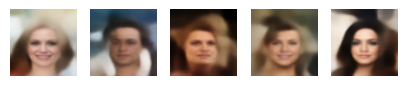

In [74]:
transform =transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = datasets.CelebA('./data', split='train',download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

celebVae = ConvVAE(size=64, latent_dim=128)
celebvOptimizer = optim.Adam(celebVae.parameters(), lr=1e-3)
for epoch in range(1, 11):
    train(celebVae, train_loader, celebvOptimizer, epoch)
generate_images(celebVae, num_images=5, latent_dim=128)

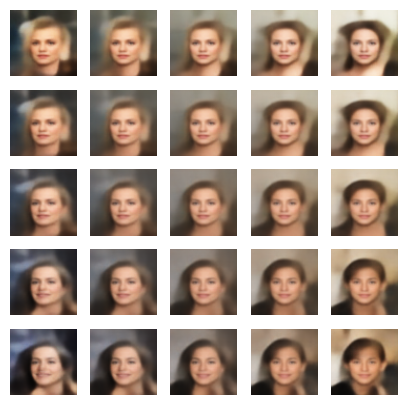

In [76]:
interpolate_images(celebVae, 128)

We can see that the face in the center is the most defined part of the generated images. The faces are all fairly androgenous, maybe leaning towards feminine. Longer hair is shown on the left images and shorther hair is on the right. While there are no clearly defined celebrities in the images, we can see a smooth progression as expected from the VAE.